### Agora - A Dark Web Marketplace
#### Data analysis and visualization

##### Antonio Jurlina

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir('/Users/antoniojurlina/Projects/learning_python/data/')

A few years ago, a reddit user called *usheep* scraped a DarkWeb marketplace called the Agora for a list of vendors, their identities and products, while threatening to expose them all as blackmail. Eventually, this data set made it to the general public, and while *usheep* disappeared, we have thousands of rows of vendors, items, categories, descriptions and prices in an organized data set that contains drugs, weapons, books, services, and more. There are over 100,000 unique observations spanning year 2014. My goal is to analyze this data set and explore some common items being sold, as well as the usual prices across categories.

Although there is over 1.6TB of uncompressed, scraped data of dark web sales available out [there](https://www.gwern.net/DNM-archives), the goal of this project will be to look at the Kaggle published [subset](https://www.kaggle.com/philipjames11/dark-net-marketplace-drug-data-agora-20142015) which is around 30MB and contains ~100,000 observations. The data set is available as a direct .csv download with a Kaggle account. Additonally, since all the prices listed in this data set are in Bitcoin, I went to [Coindesk](https://www.coindesk.com/price/bitcoin) and downloaded the daily closing price of Bitcoin in US Dollar amounts, for that whole period. This data set will be used to make the costs more comprehensible by converting them to current USD prices.  

In [3]:
# Importing Agora data
dw_data = pd.read_csv("Agora.csv", usecols=['Vendor', ' Category', ' Item', 
                                            ' Item Description', ' Price', ' Rating']) \
    .rename(columns={'Vendor':'vendor',
                    ' Category':'category',
                    ' Item':'item',
                    ' Item Description':'description',
                    ' Price':'price',
                    ' Rating':'rating'})

# Importing Bitcoin data and selecting out the relevant column
bitcoin = pd.read_csv("BTC_USD_2014-01-02_2015-01-01-CoinDesk.csv")
inflation = 0.1186 # the inflation rate between 2014 and 2021
bitcoin = bitcoin.iloc[:,2]*(1+inflation)

The **Agora** data set sample, as it is currently in the memory, is shown below. The variables that need to be cleaned up further are *category*, *price*, and *rating*. 

- Category: There are categories and subcategories within this column that need to be split into separate columns.
- Price: This a string because the word *BTC* is present in each and should be converted to numeric for further analysis.
- Rating: This shows the rating and the possible highest score, which should also be separated out.

In [4]:
dw_data.head()

,vendor,category,item,description,price,rating
0,CheapPayTV,Services/Hacking,12 Month HuluPlus gift Code,12-Month HuluPlus Codes for $25. They are wort...,0.05027025666666667 BTC,4.96/5
1,CheapPayTV,Services/Hacking,Pay TV Sky UK Sky Germany HD TV and much mor...,Hi we offer a World Wide CCcam Service for En...,0.152419585 BTC,4.96/5
2,KryptykOG,Services/Hacking,OFFICIAL Account Creator Extreme 4.2,Tagged Submission Fix Bebo Submission Fix Adju...,0.007000000000000005 BTC,4.93/5
3,cyberzen,Services/Hacking,VPN > TOR > SOCK TUTORIAL,How to setup a VPN > TOR > SOCK super safe enc...,0.019016783532494728 BTC,4.89/5
4,businessdude,Services/Hacking,Facebook hacking guide,. This guide will teach you how to hack Faceb...,0.062018073963963936 BTC,4.88/5


From the bitcoin data set, the only relevant variable is column 2, which has been adjusted from 2014 to 2021 USD values and extracted as a single Series. From here, I can obtain the average bitcoin value for 2014 and use it to convert all the listed prices in the Agora data set. This is not a flawless approach as the sale listings do not have specific dates associated with them and Bitcoin varies daily. Therefore, I will also use the lowest and highest Bitcoin values in USD across 2014 to show the possible price ranges. 

In [5]:
bitcoin.head()

0     860.313571
1     899.384815
2     909.776933
3     974.430167
4    1085.770018
Name: Closing Price (USD), dtype: float64

##### Cleaning Data

Below is the code that performs the data cleaning discussed above. In addition to all the steps previously outlined, I find price outliers within each category and create a new Boolean column which indicates whether each value is an outlier within its respective category. 

In this case, outliers are defined as prices that are above the threshold: 

$$price > 1.5 * IQR + 3^{rd} Quartile$$

where IQR stands for interquartile range.

In [6]:
# Cleaning the price column
dw_data = dw_data[dw_data['price'].str.contains('BTC', na=False)]
dw_data['price'] = dw_data['price'].str.replace(" BTC", "")
dw_data['price'] = pd.to_numeric(dw_data['price'])

# Separating the rating column into rating and total possible score columns
dw_data = dw_data[~dw_data['rating'].str.contains('[0 deals]', na=False)]
dw_data['rating'] = dw_data['rating'].str.replace("~", "")
ratings = dw_data['rating'].str.split("/", n=3,expand=True)
dw_data['rating'] = pd.to_numeric(ratings[0])
dw_data['rating_total'] = pd.to_numeric(ratings[1])

# separating out the categories hierarchy 
categories = dw_data['category'].str.split("/", n=3,expand=True)
categories[0] = categories[0].str.replace("^Info$", "Information")
categories_to_use = ['Services', 'Drugs', 'Forgeries', 'Tobacco', 'Counterfeits', 
                     'Data', 'Information', 'Electronics', 'Drug paraphernalia',
                     'Other', 'Jewelry', 'Weapons', 'Chemicals']
dw_data['category']  = categories[0]
dw_data['category1'] = categories[1]
dw_data['category2'] = categories[2]
dw_data['category3'] = categories[3]

dw_data = dw_data[dw_data['category'].isin(categories_to_use)].reset_index(drop=True)

# converting BTC to 2021 $USD values
dw_data['usd_low'] = np.round(np.min(bitcoin) * dw_data['price'], 2)
dw_data['usd'] = np.round(np.mean(bitcoin) * dw_data['price'], 2)
dw_data['usd_high'] = np.round(np.max(bitcoin) * dw_data['price'], 2)

# adding a column that signifies which value is an outlier within top level category
def limit(column):
    iqr = column.quantile(0.75) - column.quantile(0.25)
    top = column.quantile(0.75) + 1.5*iqr
    return top

limits = dw_data.groupby('category')['usd'].agg(limit) \
    .reset_index().rename(columns={'usd':'limit'})

dw_data = dw_data.merge(limits, on='category', how='left')

dw_data['outlier'] = dw_data['usd'] > dw_data['limit']
dw_data = dw_data.drop('limit', axis=1)

# deleting all intermediate data frames
del [categories, categories_to_use, ratings, limits]

The resulting data frame is presented below.

In [7]:
print(dw_data.shape)
dw_data.head()

(73314, 14)


,vendor,category,item,description,price,rating,rating_total,category1,category2,category3,usd_low,usd,usd_high,outlier
0,CheapPayTV,Services,12 Month HuluPlus gift Code,12-Month HuluPlus Codes for $25. They are wort...,0.050270,4.96,5.0,Hacking,None,None,17.23,29.60,54.58,False
1,CheapPayTV,Services,Pay TV Sky UK Sky Germany HD TV and much mor...,Hi we offer a World Wide CCcam Service for En...,0.152420,4.96,5.0,Hacking,None,None,52.25,89.74,165.49,False
2,KryptykOG,Services,OFFICIAL Account Creator Extreme 4.2,Tagged Submission Fix Bebo Submission Fix Adju...,0.007000,4.93,5.0,Hacking,None,None,2.40,4.12,7.60,False
3,cyberzen,Services,VPN > TOR > SOCK TUTORIAL,How to setup a VPN > TOR > SOCK super safe enc...,0.019017,4.89,5.0,Hacking,None,None,6.52,11.20,20.65,False
4,businessdude,Services,Facebook hacking guide,. This guide will teach you how to hack Faceb...,0.062018,4.88,5.0,Hacking,None,None,21.26,36.51,67.34,False


##### Market Size

Here, I present all the distinct categories that span the hierarchy of all listings on the Agora. For each distinct category, the size represents the total number of items being sold while the two values listed represent the total  value of the entire marketplace (category) in 2021 US Dollars. In each graph, there is a top and a bottom Value plot. The top one is simply all the values added up while the bottom one is all the values added up but with the outliers removed. 

According to the number of listings and to the entire value of all items listed combined, the marketplace for Drugs on the Agora is the largest one, by far. With over 60,000 listings, and a combined value of over $900 million, it dwarves other categories.

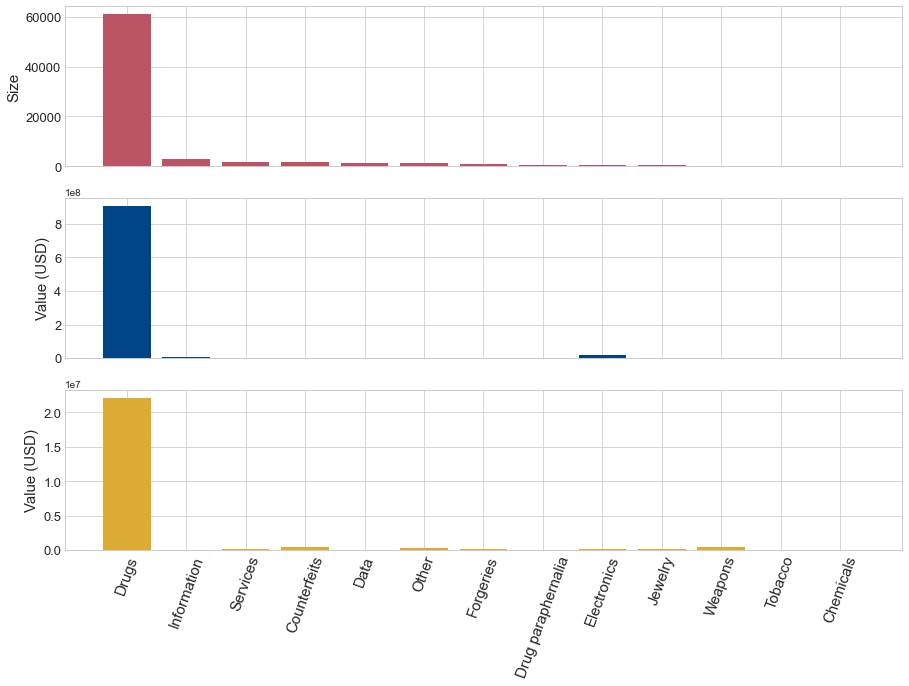

In [8]:
markets = dw_data.groupby('category')['usd'].agg([sum, np.size]).reset_index() \
                 .merge(dw_data[~dw_data['outlier']] \
                        .groupby('category')['usd'] \
                        .sum().reset_index(), on='category', how='left') \
                 .rename(columns={'usd':'sum_no'})\
                 .sort_values('size', ascending=False).set_index('category')

plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,10))

ax[0].bar(markets.index, markets['size'], color = "#BB5566")
ax[0].set_xticklabels(markets.index, rotation=70, size = 15)
ax[0].tick_params(axis='y', labelsize= 13)
ax[0].set_ylabel("Size", size = 15)
ax[1].bar(markets.index, markets['sum'], color = "#004488")
ax[1].set_xticklabels(markets.index, rotation=70, size = 15)
ax[1].tick_params(axis='y', labelsize= 13)
ax[1].set_ylabel("Value (USD)", size = 15)
ax[2].bar(markets.index, markets['sum_no'], color = "#DDAA33")
ax[2].set_xticklabels(markets.index, rotation=70, size = 15)
ax[2].tick_params(axis='y', labelsize= 13)
ax[2].set_ylabel("Value (USD)", size = 15)
plt.show()

Given such a pronounced difference between the Drugs marketplace and all the other ones, I created a second version of the plot above, but with the Drugs bar removed. The remaining categories are sorted by the number of listings. The graph at the very bottom is cleared of all outlier effects and shows that Counterfeits and Weapons steadily outpace other categories in the total value of items being sold.

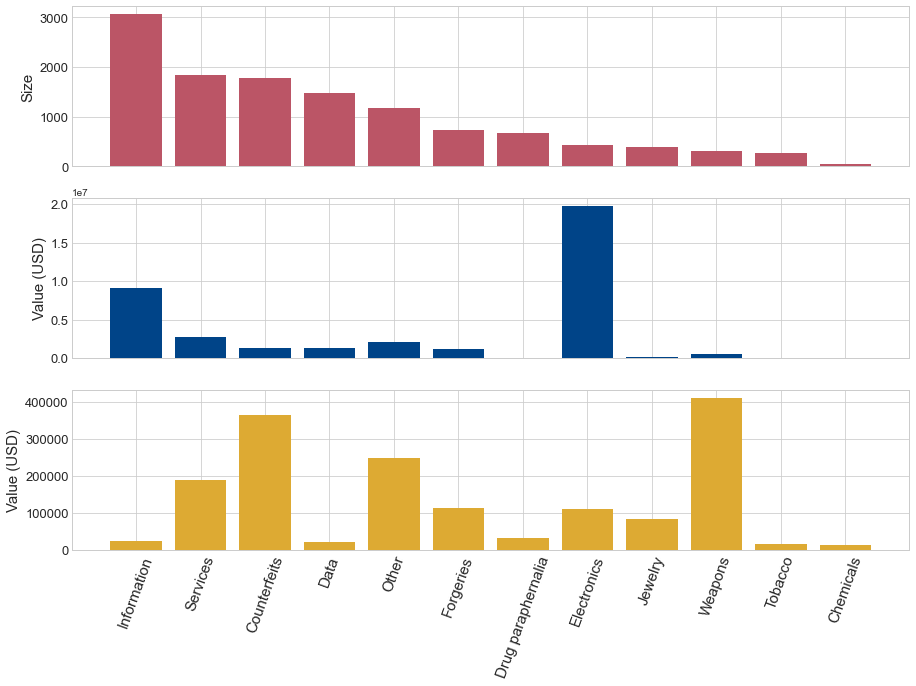

In [9]:
markets_no = markets[markets.index != 'Drugs'].sort_values('size', ascending=False)

plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,10))

ax[0].bar(markets_no.index, markets_no['size'], color = "#BB5566")
ax[0].set_xticklabels(markets_no.index, rotation=70, size = 15)
ax[0].tick_params(axis='y', labelsize= 13)
ax[0].set_ylabel("Size", size = 15)
ax[1].bar(markets_no.index, markets_no['sum'], color = "#004488")
ax[1].set_xticklabels(markets_no.index, rotation=70, size = 15)
ax[1].tick_params(axis='y', labelsize= 13)
ax[1].set_ylabel("Value (USD)", size = 15)
ax[2].bar(markets_no.index, markets_no['sum_no'], color = "#DDAA33")
ax[2].set_xticklabels(markets_no.index, rotation=70, size = 15)
ax[2].tick_params(axis='y', labelsize= 13)
ax[2].set_ylabel("Value (USD)", size = 15)
plt.show()

##### Weapons

In [10]:
weapons_of_interest = ['Glock', 'Ruger', 'Walther', 'Beretta', 'AK-47']
weapons_df = pd.DataFrame(columns=['item', 'price', 'usd'])

for i in range(5):
    subset = dw_data[dw_data['category1'] == 'Lethal firearms']
    subset = subset[subset['item'].str.contains(weapons_of_interest[i], na=False)]
    weapons_df = weapons_df.append(subset[weapons_df.columns], ignore_index=True)

weapons_df['weapon'] = 'weapon'

for i in range(5):
    weapons_df.loc[:, 'weapon'][weapons_df['item'] \
    .str.contains(weapons_of_interest[i], na=False)] = weapons_of_interest[i]

weapons_df = weapons_df.reset_index(drop=True)

del [subset, i, weapons_of_interest]

print(weapons_df.shape)
weapons_df.head()

(67, 4)


,item,price,usd,weapon
0,Glock 19 Gen 3 9mm & 2 Mags,4.862971,2863.12,Glock
1,Glock 17 3rd Gen FULL ESCROW,3.656912,2153.04,Glock
2,Glock 21SF 45 ACP FULL ESCROW,3.656912,2153.04,Glock
3,Glock 20 10MM FULL ESCROW,3.656912,2153.04,Glock
4,Glock 26 gen 3 9mm & 2 mags,4.598510,2707.41,Glock


Here, I create a data frame listing all the popular weapons brands, most of which can be found in the US legally. The names were extracted from the item descriptions and median prices were obtained for each brand. 

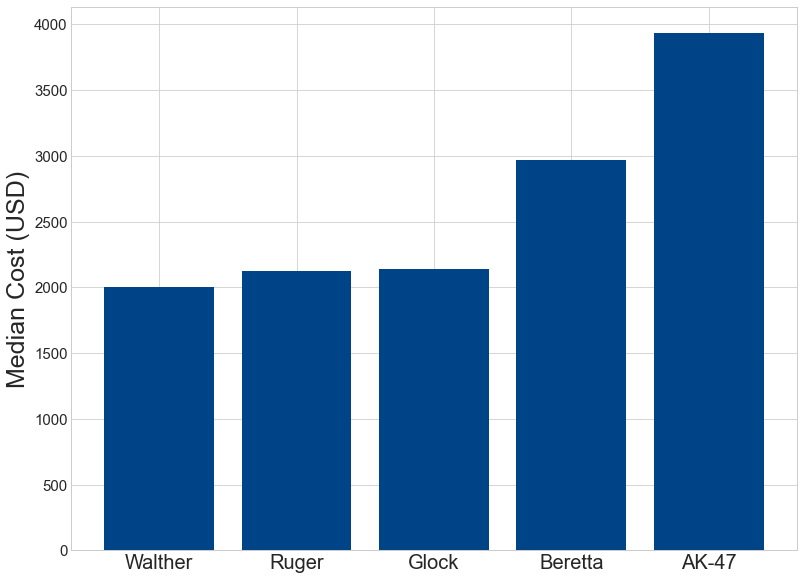

In [11]:
weapons = weapons_df.groupby('weapon')['usd'].median() \
    .reset_index().sort_values('usd') \
    .set_index('weapon')

plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(13,10))

ax.bar(weapons.index, weapons['usd'], color = '#004488')
ax.set_xticklabels(weapons.index, size = 20)
ax.tick_params(axis='y', labelsize= 15)
ax.set_ylabel("Median Cost (USD)", size = 25)

plt.show()

Buying weapons illegaly, compared to the usual US prices, is significantly more expensive. The median price for each brand listen on the Agora is anywhere between two to five times more expensive than if purchased from an accredited weapons dealer. Further analysis would be interesting here to determine the specific difference between legal prices and the ones from the Dark Web. Currently, that is beyond the scope of this project. 

##### Drugs

In [12]:
drugs = dw_data[dw_data['category']=='Drugs'].groupby('category1')['usd'] \
    .agg([sum, np.size]).reset_index().sort_values('size', ascending=False) \
    .set_index('category1')

print(drugs.shape)
drugs.head()

(13, 2)


,sum,size
category1,,
Cannabis,5.200670e+08,20542.0
Ecstasy,1.700251e+08,9654.0
Stimulants,1.852040e+08,8474.0
Psychedelics,9.215761e+06,5384.0
Opioids,7.974575e+06,4474.0


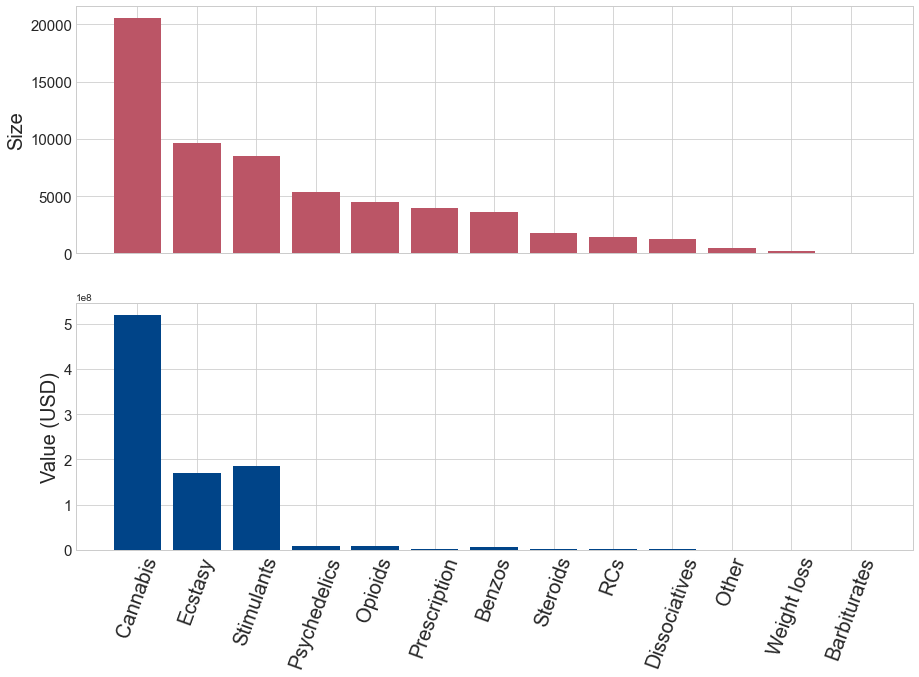

In [13]:
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,10))

ax[0].bar(drugs.index, drugs['size'], color = '#BB5566')
ax[0].set_xticklabels(drugs.index, rotation=70, size = 20)
ax[0].tick_params(axis='y', labelsize= 15)
ax[0].set_ylabel("Size", size = 20)
ax[1].bar(drugs.index, drugs['sum'], color = '#004488')
ax[1].set_ylabel("Value (USD)", size = 20)
ax[1].set_xticklabels(drugs.index, rotation=70, size = 20)
ax[1].tick_params(axis='y', labelsize= 15)

plt.show()

As pictured above, cannabis sales are much higher than those from all the other types of drugs sold on the Agora. Both in total market value (over $500 million) and market size (over 20,000 listings), illegal cannabis sales (at least in 2014) were far more popular than those of any other type of drug. 

##### YouTube

In [14]:
social_media_regex = ['[Y|y][O|o][U|u][T|t][U|u][B|b][E|e]', 
                '[T|t][W|w][I|i][T|t][T|t][E|e][R|r]', 
                '[F|f][A|a][C|c][E|e][B|b][O|o][O|o][K|k]', 
                '[I|i][N|n][S|s][T|t][A|a][G|g][R|r][A|a][M|m]']
social_media = ['YouTube', 'Twitter', 'Facebook', 'Instagram']
products_regex = ['[L|l][I|i][K|k][E|e]', 
            '[S|s][U|u][B|b][S|s][C|c][R|r][I|i][B|b][E|e][R|r]', 
            '[V|v][I|i][E|e][W|w]', 
            '[C|c][O|o][M|m][M|m][E|e][N|n][T|t]']
products = ['likes', 'subscribers', 'views', 'comments']
social_media_df = pd.DataFrame(columns=['item', 'price', 'usd'])

for i in range(4):
    subset = dw_data[dw_data['category1'] == 'Advertising']
    subset = subset[subset['item'].str.contains(social_media_regex[i], na=False)]
    social_media_df = social_media_df.append(subset[social_media_df.columns], ignore_index=True)

social_media_df['company'] = 'company'
social_media_df['product'] = 'product'

for i in range(4):
    social_media_df.loc[:, 'company'][social_media_df['item'] \
    .str.contains(social_media_regex[i], na=False)] = social_media[i]

    social_media_df.loc[:, 'product'][social_media_df['item'] \
    .str.contains(products_regex[i], na=False)] = products[i]

social_media_df = social_media_df[social_media_df['product'] != 'product'] \
    .reset_index(drop=True)

quantity = social_media_df['item'] \
    .str.extract('(\\d[\\s|\\d]?\\d?\\d?\\s?\\d?\\d?\\d?\\s?\\d?\\d?\\d?)',\
         expand=False).str.replace('\\s', "")

social_media_df['quantity'] = pd.to_numeric(quantity)
social_media_df.loc[64, 'quantity'] = 5000

social_media_df['unit_price'] = social_media_df['price'] / social_media_df['quantity']
social_media_df['unit_usd'] = social_media_df['usd'] / social_media_df['quantity']

del [social_media_regex, social_media, 
     products_regex, products, subset, i,
     quantity]

print(social_media_df.shape)
social_media_df.head()

(74, 8)


,item,price,usd,company,product,quantity,unit_price,unit_usd
0,100 Youtube likes just 8 USD!,0.032760,19.29,YouTube,likes,100,0.000328,0.192900
1,100 Youtube subscriber just 10 USD!,0.040950,24.11,YouTube,subscribers,100,0.000409,0.241100
2,100 Youtube unlike just 10 USD!,0.040929,24.10,YouTube,likes,100,0.000409,0.241000
3,1000 Youtube views just 10 USD,0.040960,24.12,YouTube,views,1000,0.000041,0.024120
4,500 000 Real High Retention Youtube views,2.747742,1617.76,YouTube,views,500000,0.000005,0.003236


Gathering social media content into a coherent data frame was a little more work. The code above extracts the per unit cost in purchasing an additional like, subscriber, view or comment for a given social media account. Most listings are regarding Facebook and Youtube. The code above uses the item descriptions to extract the number and type of unit being sold, and creates several new columns that reflect this while facilitating further analysis. 

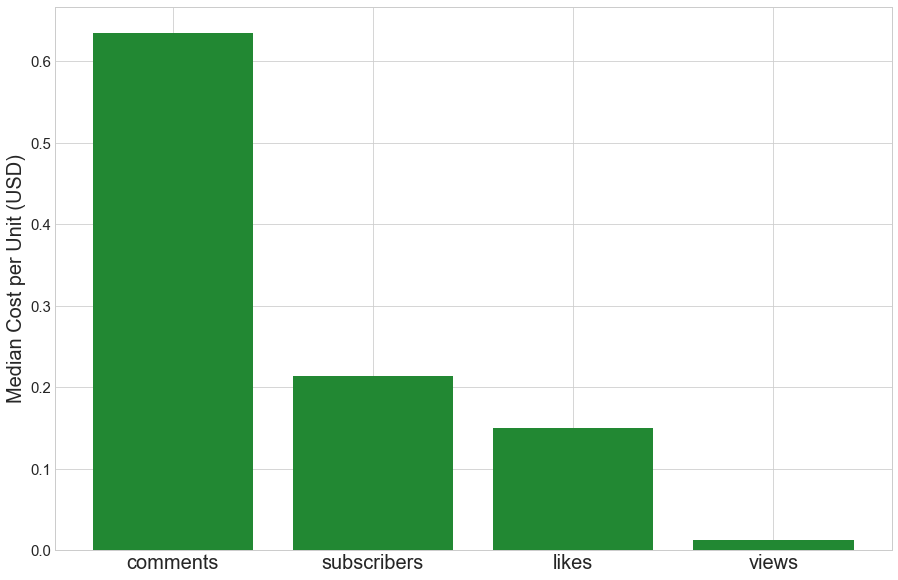

In [16]:
youtube = social_media_df[social_media_df['company']=='YouTube'] \
    .groupby('product')['unit_usd'].median().reset_index() \
    .sort_values('unit_usd', ascending=False).set_index('product')  

plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(15,10))

ax.bar(youtube.index, youtube['unit_usd'], color = '#228833')
ax.set_xticklabels(youtube.index, size = 20)
ax.tick_params(axis='y', labelsize= 15)
ax.set_ylabel("Median Cost per Unit (USD)", size = 20)

plt.show() 

Pictured above, is the data for YouTube. According to all the postings, each additional comment was worth around 60 cents of a 2021 USD, putting it higher than subscribers, likes or views. Vast majority of these listings indicate that each product is of 'high quality' meaning they are such that bot detecting software would not cleanse them. This usually indicates click farms (mostly from third world countries in which people are paid to constantly create new accounts and provide social media engagement) but such a claim cannot be ascertained from given data alone. 

Below, I quickly calculate the expected per-unit-cost of a Facebook like, which seems to be a somewhat lower value than YouTube likes.

In [43]:
fb_like = social_media_df[(social_media_df['company']=='Facebook') \
              & (social_media_df['product']=='likes')] \
                  .loc[:, 'unit_usd'].median()

print("The expected per-unit cost of a Facebook like is", round(fb_like*100, 2), "cents (2021 $USD).")

The expected per-unit cost of a Facebook like is 12.48 cents (2021 $USD).


##### Documents

In [18]:
doc_regex = ['[P|p]assport', '[D|d]river[\']?s[\\s]?']
doc = ["Passport", "Driver's License"]

docs_df = pd.DataFrame(columns=['item', 'price', 'usd'])

for i in range(2):
    subset = dw_data[dw_data['category1'] == 'Physical documents']
    subset = subset[subset['item'].str.contains(doc_regex[i], na=False)]
    docs_df = docs_df.append(subset[docs_df.columns], ignore_index=True)

docs_df['document'] = 'document'

for i in range(2):
    docs_df.loc[:, 'document'][docs_df['item'] \
    .str.contains(doc_regex[i], na=False)] = doc[i]

docs_df.loc[:, 'document'][docs_df['item'] \
    .str.contains('Passport[\\s]?[+]')] = "Passport+ID+Driver's License"

docs_df = docs_df[~docs_df['item'].str.contains('emplate')].reset_index(drop=True)

del [doc, doc_regex, i, subset]

print(docs_df.shape)
docs_df.head()

(114, 4)


,item,price,usd,document
0,Fake Danish Passport,2.808987,1653.82,Passport
1,Fake Lithuanian Passport (old version),3.803150,2239.14,Passport
2,Fake Lithuanian Passport,2.475635,1457.55,Passport
3,Netherlands Physical Passport + DL + ID CARD,7.761003,4569.36,Passport+ID+Driver's License
4,Pysical Fake Passports and IDs,0.015551,9.16,Passport


This data frame was created in a way similar to the social media one. Item descriptions were used to separate out the type of 'product' being sold. Three specific groups were identified: Passports, Driver's Licenses and a combination product of Passport, ID and Driver's License. These are worldwide so documents belong to numerous countries and/or states. For the sake of simplicity, the median cost is calculated on a worldwide basis. Counterfeit document listing also include a lot of templates being sold, which were filtered out, given that their values were significantly lower. 

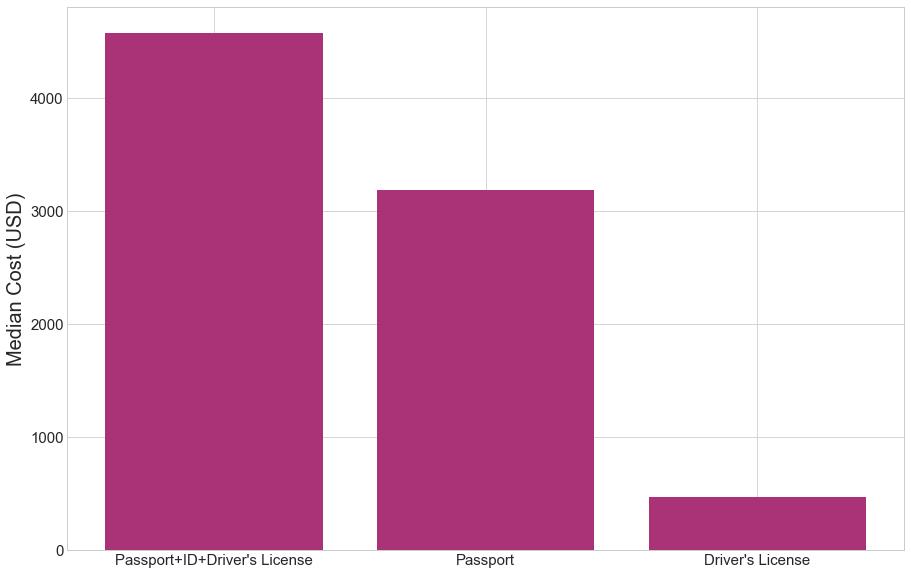

In [20]:
documents = docs_df.groupby('document')['usd'].median().reset_index() \
    .sort_values('usd', ascending=False).set_index('document')  

plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(15,10))

ax.bar(documents.index, documents['usd'], color = '#AA3377')
ax.set_xticklabels(documents.index, size = 15)
ax.set_ylabel("Median Cost (USD)", size = 20)
ax.tick_params(axis='y', labelsize= 15)

plt.show() 

Median costs were calcualted given that there are numerous countries listed, with varying degrees of value associated with their documentation, as well as several prominent outliers. While this category provides listings for real documents, that is, documents that are actually harder to detect as illegaly obtained and that exist in some database, there are many from the *Fake* category that slip into this one. They usually cost much less but the wording in the item description is difficult to use in filtering them out. Hopefully, the median expectation protects against these outlier effects.

##### Cigarettes

In [21]:
cigs_regex = ['[D|d][U|u][N|n][H|h][I|i][L|l][L|l]', 
              '[B|b][O|o][N|n][D|d]',
              '[V|v][O|o][G|g][U|u][E|e]',
              '[W|w][I|i][N|n][S|s][T|t][O|o][N|n]',
              '[M|m][A|a][R|r][L|l][B|b][O|o][R|r][O|o]',
              '[P|p][A|a][L|l][L|l][\\s]?[M|m][A|a][L|l][L|l]',
              '[L|l][\\s]?[&][\\s]?[M|m]',
              '[L|l][U|u][C|c][K|k][Y|y]',
              '[C|c][A|a][M|m][E|e][L|l]',
              '[C|c][H|h][E|e][S|s][T|t][E|e][R|r]',
              '[D|d][A|a][V|v][I|i][D|d][O|o]',
              '[P|p][A|a][R|r][L|l][I|i][A|a][M|m]',
              '[V|v][I|i][R|r][G|g][I|i][N|n][I|i][A|a]',
              '[R|r][E|e][D|d][\\s]?[&][\\s]?[W|w][H|h][I|i][T|t][E|e]']
cigs = ['Dunhill', 'Bond', 'Vogue', 'Winston', 'Marlboro', 'Pall Mall',
        'L&M', 'Lucky Strike', 'Camel', 'Chesterfield', 'Davidoff',
        'Parliament', 'Virginia', 'Red&White']

cigs_df = pd.DataFrame(columns=['item', 'price', 'usd'])

for i in range(10):
    subset = dw_data[dw_data['category1'] == 'Smoked']
    subset = subset[subset['item'].str.contains(cigs_regex[i], na=False)]
    cigs_df = cigs_df.append(subset[cigs_df.columns], ignore_index=True)

cigs_df['brand'] = 'brand'

for i in range(14):
    cigs_df.loc[:, 'brand'][cigs_df['item'] \
    .str.contains(cigs_regex[i], na=False)] = cigs[i]

# almost all original prices are listed for 10 packs, so I divide by 10 to get pack price
# but sometimes it's a single pack listed and that's why I did this division only when
# the total price listed was above 10USD
cigs_df['unit_cost'] = cigs_df['usd']
cigs_df.loc[:, 'unit_cost'][cigs_df['unit_cost'] > 10] = cigs_df['unit_cost'] / 10

cigs_df = cigs_df.reset_index(drop=True)

del [cigs_regex, cigs, subset, i]

print(cigs_df.shape)
cigs_df.head()

(101, 5)


,item,price,usd,brand,unit_cost
0,Dunhill Fine Cut Dark Blue (10 packs x 20 ciga...,0.160849,94.70,Dunhill,9.470
1,DUNHILL Cheap Cigarettes to USA and EU,0.156015,91.86,Dunhill,9.186
2,Dunhill Fine Cut Black (10 packs x 20 cigarettes),0.160806,94.68,Dunhill,9.468
3,Copy of Dunhill Fine Cut Black (10 packs x 20 ...,0.091288,53.75,Dunhill,5.375
4,Bond Cheap Cigarettes to USA and EU,0.088071,51.85,Bond,5.185


Again, repeating the procedure used for the social media and documentation data frames, once again I go through the item descriptions and extract all the relevant cigarette brands to group by later. Furthermore, it is clear from the description that almost every single listed price is for a product consisting of 10 packs with 20 cigarettes each. Therefore, the Bitcoin price was converted to US Dollar values, and divided by 10, to get the cost of a single pack for each brand.

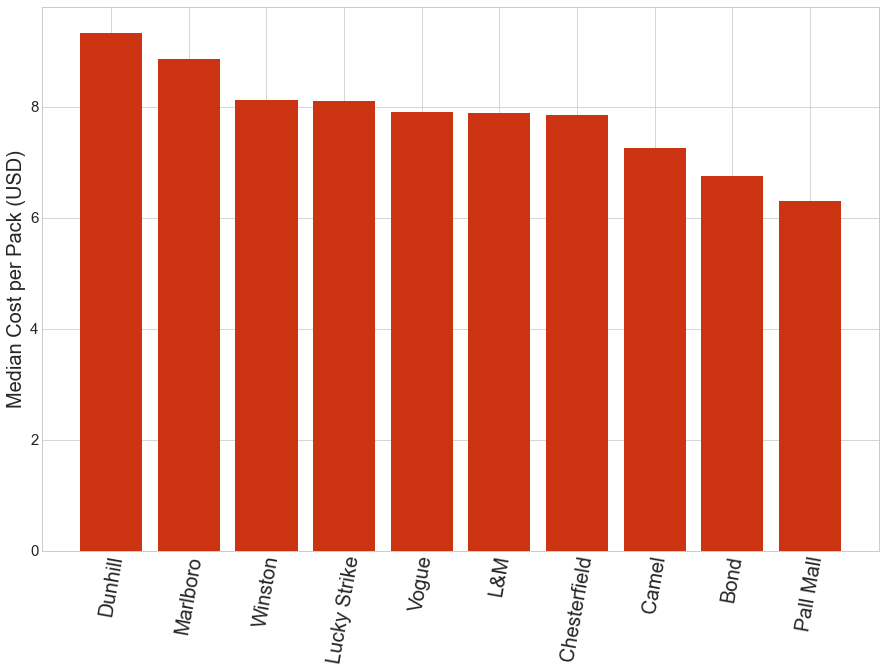

In [23]:
cigarettes = cigs_df.groupby('brand')['unit_cost'].median().reset_index() \
    .sort_values('unit_cost', ascending=False).set_index('brand')  

plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(15,10))

ax.bar(cigarettes.index, cigarettes['unit_cost'], color = '#CC3311')
ax.set_xticklabels(cigarettes.index, rotation=80, size = 20)
ax.set_ylabel("Median Cost per Pack (USD)", size = 20)
ax.tick_params(axis='y', labelsize= 15)

plt.show()

As can be seen in the plot above, the brands are sorted by cost. The prices are median costs, per pack, in 2021 \\$USD. Surprisingly, they don't differ significantly from prices in states with low to moderate taxes. However, they are much smaller than those in states like New York, which have costs of around $15 per pack, easily.

##### Conclusion

As an initial look into the illegal dealings on the Dark Web, this project is appropriate. It allows for a preliminary sense of how products are listed, what the scope of the markets is, how data is organized and what possible insights can be gleaned from it. Furthermore, it illuminates all the issues present in trying to make sense of it all. The prices are listed in Bitcoin and held online for unknown periods of time, even as Bitcoin fluctuates. Knowing the possible range for a year helps in narrowing down the expected cost values. However, error bars need to be created to show the amount of uncertainty in this approach.

With more computing power and detailed string parsing scripts, I would be willing to take a crack at the 1.6TB data set. Price differences between legal and illegal products can illuminate countless premiums customers are willing to pay on various products, which is a worthwhile endeavor for any economist to pursue.

For the data and other notebooks, see [github.com/antoniojurlina/learning_python](https://github.com/antoniojurlina/learning_python).